# **Шведова Софья**

# **Цель и задачи работы:**
1. Познакомиться с понятием «большие данные» и способами их обработки;
2. Познакомиться с инструментом Apache Spark и возможностями, которые он предоставляет для обработки больших данных.
3. Получить навыки выполнения разведочного анализа данных использованием pyspark.


Для начала надо взять датасет. Для этого на Kaggle взялись данные о спортивном зале (https://www.kaggle.com/datasets/mexwell/gym-check-ins-and-user-metadata), причем было две таблицы: users_data с данными о пользователях и checkin_checkout_history_updated с данными о приходе клиентов. С помощью SQL было соединены эти две таблицы для более подробного анализа (исходная таблица GYM.csv). Из-за того, что гитхаб поддерживает только 25 мб максимум, а сам файл весит 35 мб, то на гиитхабе представлен сжатый вид этого файла на 15000 строк https://github.com/SofiaShvedova/Lab-6.1

Импорт необходимых библиотек

In [ ]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession

from pyspark.sql.window import Window
from pyspark.sql.functions import udf, isnan, min, max, sum, count, desc, expr, avg
from pyspark.sql.types import IntegerType, LongType

from pyspark.ml.feature import StandardScaler, VectorAssembler, MinMaxScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LogisticRegression, GBTClassifier, LogisticRegressionModel, GBTClassificationModel, RandomForestClassificationModel

import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
import pandas as pd

In [ ]:
! pip install pyspark

In [ ]:
# Импорт модулей, связанных с PySpark.
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

MAX_MEMORY = '15G'
# Инициализировать сеанс Spark.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = 'GYM.csv' # Загрузите данные в текущий каталог Colab.
# filename_data = 'data/endomondoHR.json' # Загрузите данные в каталог data/  при работе в Docker.
# Загрузите основной набор данных в фрейм данных pyspark.
df = spark.read.csv(filename_data, mode="DROPMALFORMED")
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


# **Обзор набора данных**




Надо изменить название столбцов

In [ ]:
df = df \
    .withColumnRenamed("_c0", "user_id") \
    .withColumnRenamed("_c1", "gym_id") \
    .withColumnRenamed("_c2", "checkin_time") \
    .withColumnRenamed("_c3", "checkout_time") \
    .withColumnRenamed("_c4", "workout_type") \
    .withColumnRenamed("_c5", "calories_burned") \
    .withColumnRenamed("_c6", "first_name") \
    .withColumnRenamed("_c7", "last_name") \
    .withColumnRenamed("_c8", "age") \
    .withColumnRenamed("_c9", "gender") \
    .withColumnRenamed("_c10", "birthdate") \
    .withColumnRenamed("_c11", "user_location") \
    .withColumnRenamed("_c12", "subscription_plan")

# Проверка нового именования столбцов
df.printSchema()
df.show()

root
 |-- user_id: string (nullable = true)
 |-- gym_id: string (nullable = true)
 |-- checkin_time: string (nullable = true)
 |-- checkout_time: string (nullable = true)
 |-- workout_type: string (nullable = true)
 |-- calories_burned: string (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- age: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- birthdate: string (nullable = true)
 |-- user_location: string (nullable = true)
 |-- subscription_plan: string (nullable = true)

+---------+------+-------------------+-------------------+-------------+---------------+----------+---------+---+----------+----------+-------------+-----------------+
|  user_id|gym_id|       checkin_time|      checkout_time| workout_type|calories_burned|first_name|last_name|age|    gender| birthdate|user_location|subscription_plan|
+---------+------+-------------------+-------------------+-------------+---------------+----------+---------+-

Теперь надо удалить первую строку, которая должна была быть именами столбцов, но стала первой строкой

In [ ]:
condition_to_remove = (df.user_id == "user_id") & (df.gym_id == "gym_id") & \
                      (df.checkin_time == "checkin_time") & \
                      (df.checkout_time == "checkout_time") & \
                      (df.workout_type == "workout_type") & \
                      (df.calories_burned == "calories_burned") & \
                      (df.first_name == "first_name") & \
                      (df.last_name == "last_name") & \
                      (df.age == "age") & \
                      (df.gender == "gender") & \
                      (df.birthdate == "birthdate") & \
                      (df.user_location == "user_location") & \
                      (df.subscription_plan == "subscription_plan")
df_filtered = df.filter(~condition_to_remove)
print("DataFrame после удаления строки:")
df_filtered.show()

DataFrame после удаления строки:
+---------+------+-------------------+-------------------+-------------+---------------+----------+---------+---+----------+----------+-------------+-----------------+
|  user_id|gym_id|       checkin_time|      checkout_time| workout_type|calories_burned|first_name|last_name|age|    gender| birthdate|user_location|subscription_plan|
+---------+------+-------------------+-------------------+-------------+---------------+----------+---------+---+----------+----------+-------------+-----------------+
|user_3291| gym_6|2023-09-10 15:55:00|2023-09-10 16:34:00|Weightlifting|            462|   Michael|Rodriguez| 41|    Female|1998-03-10|      Atlanta|              Pro|
|user_1944| gym_2|2023-04-13 20:07:00|2023-04-13 22:43:00|         Yoga|           1278|   Michael|   Garcia| 24|    Female|1985-11-28|    Las Vegas|              Pro|
| user_958| gym_7|2023-06-10 12:24:00|2023-06-10 13:49:00|       Cardio|            858|     Emily|Rodriguez| 37|      Male|198

Посмотреть типы данных. Все типы данных – это строка, поэтому нужно будет их изменить.



In [ ]:
print('Обзор данных')
df_filtered.printSchema()
print('Обзор столбцов')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Обзор данных
root
 |-- user_id: string (nullable = true)
 |-- gym_id: string (nullable = true)
 |-- checkin_time: string (nullable = true)
 |-- checkout_time: string (nullable = true)
 |-- workout_type: string (nullable = true)
 |-- calories_burned: string (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- age: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- birthdate: string (nullable = true)
 |-- user_location: string (nullable = true)
 |-- subscription_plan: string (nullable = true)

Обзор столбцов


,Column Name,Data type
0,user_id,string
1,gym_id,string
2,checkin_time,string
3,checkout_time,string
4,workout_type,string
5,calories_burned,string
6,first_name,string
7,last_name,string
8,age,string
9,gender,string


Изменение типов данных, а именно возраст и калории, которые человек сжег – на целое число, а день рождения, дата прибытие и дата ухода – на время

In [ ]:
df_filtered1 = df_filtered.withColumn("checkin_time", df_filtered["checkin_time"].cast(TimestampType())) \
       .withColumn("checkout_time", df_filtered["checkout_time"].cast(TimestampType())) \
       .withColumn("calories_burned", df_filtered["calories_burned"].cast(IntegerType())) \
       .withColumn("age", df_filtered["age"].cast(IntegerType())) \
       .withColumn("birthdate", df_filtered["birthdate"].cast(TimestampType()))

# Показать DataFrame после изменения типов и новые типы столбцов
print("DataFrame после изменения типов столбцов:")
df_filtered1.printSchema()
pd.DataFrame(df_filtered1.dtypes, columns = ['Column Name','Data type'])

DataFrame после изменения типов столбцов:
root
 |-- user_id: string (nullable = true)
 |-- gym_id: string (nullable = true)
 |-- checkin_time: timestamp (nullable = true)
 |-- checkout_time: timestamp (nullable = true)
 |-- workout_type: string (nullable = true)
 |-- calories_burned: integer (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- birthdate: timestamp (nullable = true)
 |-- user_location: string (nullable = true)
 |-- subscription_plan: string (nullable = true)



,Column Name,Data type
0,user_id,string
1,gym_id,string
2,checkin_time,timestamp
3,checkout_time,timestamp
4,workout_type,string
5,calories_burned,int
6,first_name,string
7,last_name,string
8,age,int
9,gender,string


Всего строк 300 000

In [ ]:
print('Описание фрейма данных (только строковые и числовые столбцы):')
df_filtered1.describe().toPandas()

print(f'Общее количество {df_filtered1.count()} строк, печатаем несколько первых строк:')
df_filtered1.limit(2).toPandas()

Описание фрейма данных (только строковые и числовые столбцы):
Общее количество 300000 строк, печатаем несколько первых строк:


,user_id,gym_id,checkin_time,checkout_time,workout_type,calories_burned,first_name,last_name,age,gender,birthdate,user_location,subscription_plan
0,user_3291,gym_6,2023-09-10 15:55:00,2023-09-10 16:34:00,Weightlifting,462,Michael,Rodriguez,41,Female,1998-03-10,Atlanta,Pro
1,user_1944,gym_2,2023-04-13 20:07:00,2023-04-13 22:43:00,Yoga,1278,Michael,Garcia,24,Female,1985-11-28,Las Vegas,Pro


# **Обнаружение пропущенных значений и аномальных нулей.**

In [ ]:
print('Обзор столбцов')
pd.DataFrame(df_filtered1.dtypes, columns = ['Column Name','Data type'])

Обзор столбцов


,Column Name,Data type
0,user_id,string
1,gym_id,string
2,checkin_time,timestamp
3,checkout_time,timestamp
4,workout_type,string
5,calories_burned,int
6,first_name,string
7,last_name,string
8,age,int
9,gender,string


Затем нужно обнаружить пропущенные значения и аномальных нулей. Для этого для каждого типа данных – целое, числовое и массив надо установить поиск пропущенных значений, а именно 0, NaN, None, Null

In [ ]:
string_columns = ['user_id', 'gym_id', 'workout_type', 'first_name', 'last_name', 'gender', 'user_location', 'subscription_plan']
numeric_columns = ['age','calories_burned']
array_columns = ['checkin_time', 'birthdate', 'checkin_time']
missing_values = {}
for index, column in enumerate(df_filtered1.columns):
    if column in string_columns:    # проверить столбцы строк со значениями None и Null
#         missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
#         missing_values.update({column: missing_count})
        missing_count = df_filtered1.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in numeric_columns:  # check zeroes, None, NaN
        missing_count = df_filtered1.where(col(column).isin([0,None,np.nan])).count()
        missing_values.update({column:missing_count})

missing_df = pd.DataFrame.from_dict([missing_values])
missing_df

,user_id,gym_id,workout_type,calories_burned,first_name,last_name,age,gender,user_location,subscription_plan
0,0,0,0,0,0,0,0,0,0,0


Нулевых значений не обнаружено

# **Расчет статистических показателей признаков**

Расчет квартилей сброшенных калорий. 1 квартиль равен 534 калории, второй 834 калории, а третий – 1179

In [ ]:
from pyspark.sql.functions import col, avg, percentile_approx

quartiles = df_filtered1.select(
    percentile_approx("calories_burned", 0.25).alias("1st_quartile"),
    percentile_approx("calories_burned", 0.5).alias("2nd_quartile"),
    percentile_approx("calories_burned", 0.75).alias("3rd_quartile")
)

quartiles.show()

+------------+------------+------------+
|1st_quartile|2nd_quartile|3rd_quartile|
+------------+------------+------------+
|         534|         834|        1179|
+------------+------------+------------+



Вывод аномальных значений (покажутся все те значения, где значений сброшенных калорий будет больше 2146)

In [ ]:
from pyspark.sql import functions as F
quartiles = df_filtered1.select(
    F.percentile_approx("calories_burned", 0.25).alias("1st_quartile"),
    F.percentile_approx("calories_burned", 0.5).alias("2nd_quartile"),
    F.percentile_approx("calories_burned", 0.75).alias("3rd_quartile")
).collect()[0]  # Получение результатов как строка

Q1 = quartiles[0]
Q2 = quartiles[1]
Q3 = quartiles[2]

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

anomalies = df_filtered1.filter((col("calories_burned") < lower_bound) | (col("calories_burned") > upper_bound))

anomalies.show()

+---------+------+-------------------+-------------------+------------+---------------+----------+---------+---+----------+-------------------+-------------+-----------------+
|  user_id|gym_id|       checkin_time|      checkout_time|workout_type|calories_burned|first_name|last_name|age|    gender|          birthdate|user_location|subscription_plan|
+---------+------+-------------------+-------------------+------------+---------------+----------+---------+---+----------+-------------------+-------------+-----------------+
|user_1500| gym_7|2023-07-15 08:35:00|2023-07-15 11:30:00|    Swimming|           2147|   Michael| Williams| 32|Non-binary|1988-12-29 00:00:00|      Atlanta|            Basic|
+---------+------+-------------------+-------------------+------------+---------------+----------+---------+---+----------+-------------------+-------------+-----------------+



Затем нужно рассчитать средние, медиану, моду, дисперсию и стандартное отклонение для возраста и сожжённых калорий. Как можно заметить на рисунке 12, средний возраст – 41, медиана тоже 41, мода 64, дисперсия равна 183, а среднее отклонение – 13 лет. Среднее количество сожженных калорий – 886, медиана 834, мода – 490, дисперсия 187225, среднее отклонение 432.


In [ ]:
statistics = df_filtered1.select(
    F.avg("calories_burned").alias("avg_calories_burned"),
    F.percentile_approx("calories_burned", 0.5).alias("median_calories_burned"),
    F.mode("calories_burned").alias("mode_calories_burned"),
    F.variance("calories_burned").alias("variance_calories_burned"),
    F.stddev("calories_burned").alias("stddev_calories_burned"),
    F.avg("age").alias("avg_age"),
    F.percentile_approx("age", 0.5).alias("median_age"),
    F.mode("age").alias("mode_age"),
    F.variance("age").alias("variance_age"),
    F.stddev("age").alias("stddev_age")
)

statistics.show()

+-------------------+----------------------+--------------------+------------------------+----------------------+--------+----------+--------+------------------+------------------+
|avg_calories_burned|median_calories_burned|mode_calories_burned|variance_calories_burned|stddev_calories_burned| avg_age|median_age|mode_age|      variance_age|        stddev_age|
+-------------------+----------------------+--------------------+------------------------+----------------------+--------+----------+--------+------------------+------------------+
|  886.0887433333334|                   834|                 490|       187225.3156790078|     432.6954075085704|41.21695|        41|      64|183.29018033143657|13.538470383741162|
+-------------------+----------------------+--------------------+------------------------+----------------------+--------+----------+--------+------------------+------------------+



# **Визуализация распределения наиболее важных признаков**

Для начала нужно посмотреть, как распределяются калории, сжигаемые за тренировку. Как можно увидеть, сжигается в основном от 400 до 1000 калорий

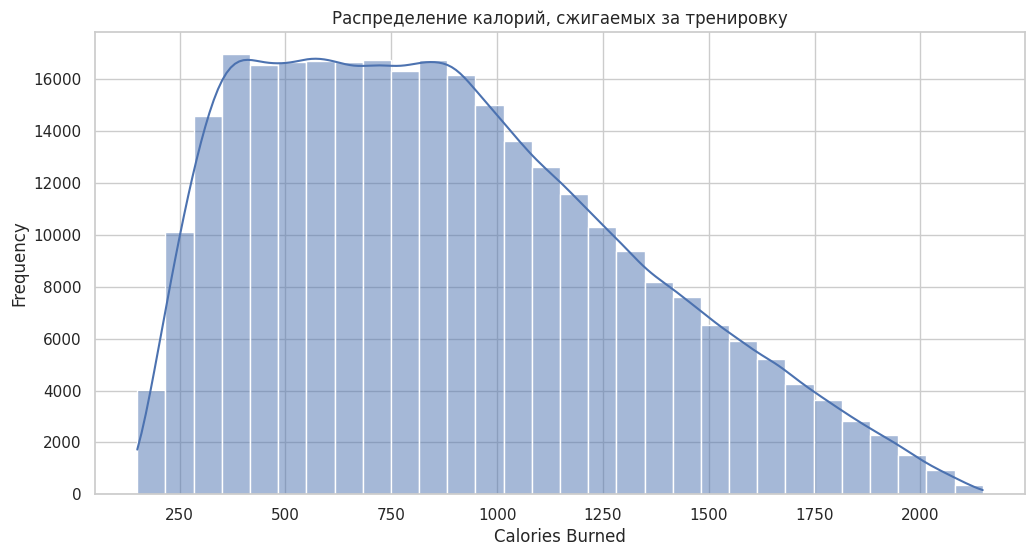

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_filtered1_pandas = df_filtered1.select('calories_burned', 'age', 'gender').toPandas()

sns.set(style="whitegrid")

# Гистограмма для calories_burned
plt.figure(figsize=(12, 6))
sns.histplot(df_filtered1_pandas['calories_burned'], bins=30, kde=True)
plt.title('Распределение калорий, сжигаемых за тренировку')
plt.xlabel('Calories Burned')
plt.ylabel('Frequency')
plt.show()


Затем нужно посмотреть, как распределяется возраст клиентов, которые посещают спортзал, для этого подойдет тип диаграммы боксплот. Диапазон от 30 до 55 лет

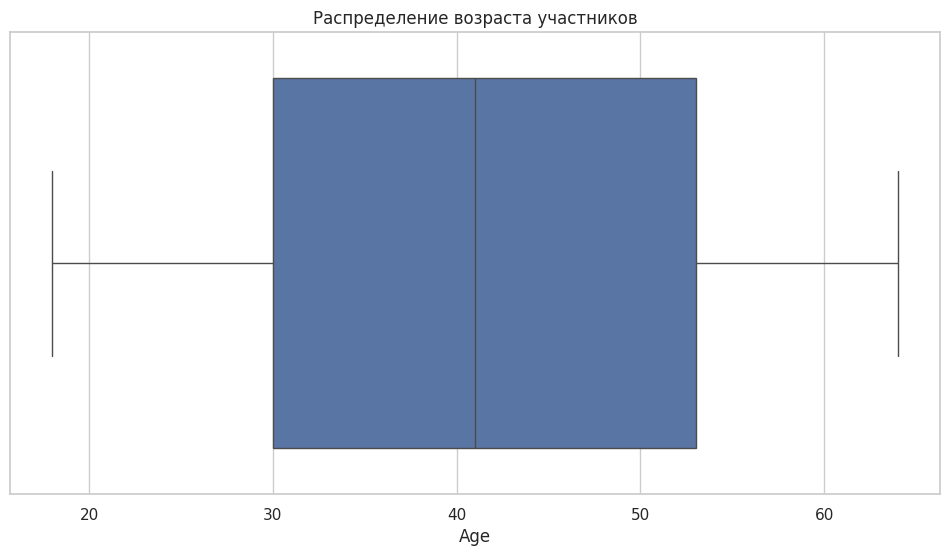

In [ ]:
# Боксплот для age
plt.figure(figsize=(12, 6))
sns.boxplot(x='age', data=df_filtered1_pandas)
plt.title('Распределение возраста участников')
plt.xlabel('Age')
plt.show()

Осталось посмотреть, какое распределение идет по полу клиентов, для этого успешно справится столбчатая диаграмма. Как можно увидеть, что мужчин на 9 тысяч больше, чем женщин, но при этом есть небинарные, их 30 тысяч

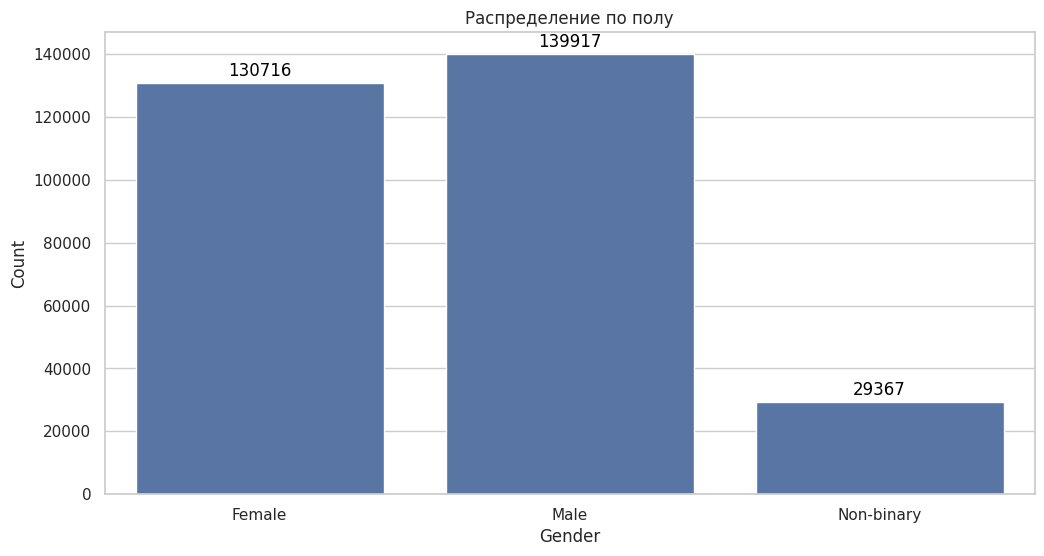

In [ ]:
# Столбчатая диаграмма для gender
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='gender', data=df_filtered1_pandas)
plt.title('Распределение по полу')
plt.xlabel('Gender')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline',
                fontsize=12, color='black',
                xytext=(0, 5),
                textcoords='offset points')

plt.show()

# **Корреляция между признаками**

In [ ]:
from pyspark.sql.functions import col
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
numerical_features = ['calories_burned', 'age']
df_numerical = df_filtered1.select(numerical_features)

assembler = VectorAssembler(inputCols=numerical_features, outputCol='features')
df_vector = assembler.transform(df_numerical)

correlation_matrix = Correlation.corr(df_vector, 'features').head()[0].toArray()

print("Корреляционная матрица:")
print(correlation_matrix)

Корреляционная матрица:
[[1.00000000e+00 4.03357456e-04]
 [4.03357456e-04 1.00000000e+00]]


Значение 4.03357456e-04 (или 0.000403) — это корреляция между calories_burned и age. Это значение очень близко к 0, что означает очень слабую или практически отсутствующую линейную зависимость между этими двумя переменными.

# **Несколько UDF для работы с данными**

UDF используются для расширения функций платформы и повторного использования этих функций в нескольких DataFrame. Например, требуется преобразовать каждую первую букву слова в строке имени в заглавную; Встроенные функции PySpark не имеют этой функции, поэтому можно создать UDF и повторно использовать ее по мере необходимости во многих кадрах данных. После создания UDF их можно повторно использовать в нескольких выражениях DataFrame и SQL.

Извлечение возраста из даты рождения

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from datetime import datetime
def calculate_age(birthdate):
    if birthdate is not None:
        birthdate = datetime.strptime(birthdate, '%Y-%m-%d')
        today = datetime.today()
        age = today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day))
        return age
    return None

calculate_age_udf = udf(calculate_age, IntegerType())

df_with_age = df_filtered1.withColumn("calculated_age", calculate_age_udf(df_filtered1.birthdate))

Преобразование времени в минуты

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql.types import LongType

def time_to_minutes(checkin_time, checkout_time):
    if checkin_time is not None and checkout_time is not None:
        checkin = datetime.strptime(checkin_time, '%Y-%m-%d %H:%M:%S')
        checkout = datetime.strptime(checkout_time, '%Y-%m-%d %H:%M:%S')
        return int((checkout - checkin).total_seconds() / 60)
    return None

time_to_minutes_udf = udf(time_to_minutes, LongType())

df_with_duration = df_with_age.withColumn("duration_minutes", time_to_minutes_udf(col("checkin_time"), col("checkout_time")))

Кодирование пола

In [ ]:
def encode_gender(gender):
    if gender == 'Male':
        return 1
    elif gender == 'Female':
        return 0
    return None

encode_gender_udf = udf(encode_gender, IntegerType())

df_encoded_gender = df_with_duration.withColumn("gender_encoded", encode_gender_udf(df_with_duration.gender))

Объединение всех UDF

In [ ]:
df_final = df_filtered1 \
    .withColumn("calculated_age", calculate_age_udf(df_filtered1.birthdate)) \
    .withColumn("duration_minutes", time_to_minutes_udf(col("checkin_time"), col("checkout_time"))) \
    .withColumn("gender_encoded", encode_gender_udf(df_filtered1.gender))

Тем самым возраст может быть критически важным показателем для дальнейшей аналитики, кодировка пола полезна в машинном обучении, в том числе и в корреляционном анализе, а преобразование времени в минуты упростит расчёты.

# **Выводы:**
1.	При анализе типов признаков в датасете было установлено наличие как количественных, так и категориальных признаков. Различие в типах признаков важно для выбора подходящих методов анализа и визуализации данных.
2.	Пропущенных значений в представленном датасете не оказалось.
3.	Среди аномальных значений (выбросов) попало только 1 значение.
4.	Были рассчитаны основные статистические показатели, такие как средние значения, медианы, квартильные значения, мода, дисперсия и стандартное отклонение. Эти показатели помогают в понимании распределения данных.
5.	Визуализация данных проводилась с помощью таких типов диаграмм, как гистограмма, боксплот и столбчатая диаграмма.
6.	Анализ корреляций проводился с использованием матрицы корреляции, но зависимостей не было обнаружено.
7.	Было реализовано несколько пользовательских функций (UDF), таких, как преобразование времени в минуты, кодировка пола и извлечение возраста из даты рождения.
